This notebook contains the code relating to section 4.3 of the thesis: Patch-wise Binary Classification.

## Installations

In [ ]:
pip install tensorflow_addons

     |████████████████████████████████| 1.1 MB 5.5 MB/s 


In [ ]:
import numpy as np
import nibabel
import os
import tensorflow as tf
import matplotlib.pyplot as plt

from tqdm import tqdm

from __future__ import print_function

from skimage.transform import resize
from skimage.io import imsave
from skimage.segmentation import mark_boundaries
from skimage.exposure import rescale_intensity
from skimage import io

import keras
from keras.models import Model, Sequential
from tensorflow.keras.layers.experimental import preprocessing
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose, Dropout, BatchNormalization, Flatten, Dense
from tensorflow.keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint
from keras import backend as K
from keras.callbacks import History
from tensorflow.keras.utils import plot_model
from tensorflow_addons.optimizers import AdamW

os.getcwd()

'/content'

In [ ]:
# Synchronise Google Drive account with the Colab notebook

# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

folder  = "/content/drive/My Drive/MASTERS/Masters Project/"

Mounted at /content/drive


In [ ]:
# give permission to read data from google cloud bucket
from google.colab import auth
auth.authenticate_user()

In [ ]:
def get_tpu_strategy():
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver(
            tpu="grpc://" + os.environ["COLAB_TPU_ADDR"]
        )  # TPU detection
        print("Running on TPU ", tpu.cluster_spec().as_dict()["worker"])
    except ValueError:
        raise BaseException("ERROR: Not connected to a TPU runtime")

    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    return tf.distribute.TPUStrategy(tpu)

In [ ]:
tpu_strategy = get_tpu_strategy()

Running on TPU  ['10.35.77.226:8470']
INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Initializing the TPU system: grpc://10.35.77.226:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.35.77.226:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


## Functions for loading TFRecords

In [ ]:
def _parse_image_function(example_proto):

    """
    Reads from TFRecord file
    Returns a tf.train.Example object (can be read like a dictionary)
    """

    image_feature_description = {

        "image_raw": tf.io.FixedLenFeature([128 * 128], tf.float32),
        # "mask_raw": tf.io.FixedLenFeature([128 * 128], tf.int64),
        "mask_raw": tf.io.FixedLenFeature([1], tf.int64),
    }

    # Parse the input tf.train.Example proto using the dictionary above.
    return tf.io.parse_single_example(example_proto, image_feature_description)

def _unpack_proto(example_proto):

    """
    Extract image and mask from example_proto object
    """

    image = example_proto["image_raw"]
    image = tf.reshape(image, [128, 128, 1])

    mask = example_proto["mask_raw"]
    # mask = tf.reshape(mask, [128, 128])
    mask = tf.reshape(mask, [1])

    return image, mask


def _unpack_proto_aug(example_proto):

    """
    Extract image and mask from example_proto object
    """

    image = example_proto["image_raw"]
    image = tf.reshape(image, [128, 128, 1])

    mask = example_proto["mask_raw"]
    # mask = tf.reshape(mask, [128, 128])
    mask = tf.reshape(mask, [1])

    # DATA AUGMENTATION
    if tf.random.uniform(()) > 0.5:
      image = tf.image.flip_left_right(image)

    if tf.random.uniform(()) > 0.5:
      image = tf.image.rot90(image)

    return image, mask


def gray_2_rgb(image, mask):

  """
  Convert image and mask to rgb (3 colour channels)
  As required for input to pre-trained models
  """

  image = tf.repeat(image, repeats=[3], axis=2)
  # mask = tf.repeat(mask, repeats=[3], axis=2)

  return image, mask

In [ ]:
def optimise_dataset(ds):

  """
  Improve performance of tensorflow dataset
  """

  ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
  # ds = ds.cache()
  return ds

def prepare_data(ds, shuffle=True):
  """
  Normalise, batch, shuffle and optimise the dataset
  """
  
  if shuffle:
    ds = ds.shuffle(5000)
  batch_size = 8 * tpu_strategy.num_replicas_in_sync # 16*8 (tpu_strategy.num_replicas_in_sync value shown in output of previous cell)
  ds = ds.batch(batch_size)
  ds = optimise_dataset(ds)
  return ds


## Balance classes (empty & non-empty masks)

https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#optional_set_the_correct_initial_bias

In [ ]:
# retrieve aneurysm-positive & aneurysm-negative datasets from google cloud

train_empty_gcs_pattern = "gs://tfrecords_patches_binary/train_empty*" # specify google cloud bucket name and file name prefix
train_empty_filenames = tf.io.gfile.glob(train_empty_gcs_pattern)

train_nonempty_gcs_pattern = "gs://tfrecords_patches_binary/train_non_empty*" # specify google cloud bucket name and file name prefix
train_nonempty_filenames = tf.io.gfile.glob(train_nonempty_gcs_pattern)

train_empty_filenames, train_nonempty_filenames

(['gs://tfrecords_patches_binary/train_empty.tfrecords-0',
  'gs://tfrecords_patches_binary/train_empty.tfrecords-1',
  'gs://tfrecords_patches_binary/train_empty.tfrecords-10',
  'gs://tfrecords_patches_binary/train_empty.tfrecords-11',
  'gs://tfrecords_patches_binary/train_empty.tfrecords-12',
  'gs://tfrecords_patches_binary/train_empty.tfrecords-13',
  'gs://tfrecords_patches_binary/train_empty.tfrecords-2',
  'gs://tfrecords_patches_binary/train_empty.tfrecords-3',
  'gs://tfrecords_patches_binary/train_empty.tfrecords-4',
  'gs://tfrecords_patches_binary/train_empty.tfrecords-5',
  'gs://tfrecords_patches_binary/train_empty.tfrecords-6',
  'gs://tfrecords_patches_binary/train_empty.tfrecords-7',
  'gs://tfrecords_patches_binary/train_empty.tfrecords-8',
  'gs://tfrecords_patches_binary/train_empty.tfrecords-9'],
 ['gs://tfrecords_patches_binary/train_non_empty.tfrecords-0'])

In [ ]:
# create training dataset

train_empty_ds = tf.data.TFRecordDataset(train_empty_filenames)
train_empty_ds = train_empty_ds.map(_parse_image_function)
train_empty_ds = train_empty_ds.map(_unpack_proto_aug)

train_nonempty_ds = tf.data.TFRecordDataset(train_nonempty_filenames)
train_nonempty_ds = train_nonempty_ds.map(_parse_image_function)
train_nonempty_ds = train_nonempty_ds.map(_unpack_proto_aug)

train_datasets = [train_nonempty_ds.repeat(), train_empty_ds.repeat()]
train_ds = tf.data.experimental.sample_from_datasets(train_datasets, [0.5,0.5]) # class balancing

train_ds = prepare_data(train_ds)

Instructions for updating:
Use `tf.data.Dataset.random(...)`.


Instructions for updating:
Use `tf.data.Dataset.random(...)`.


In [ ]:
# create validation dataset

val_empty_gcs_pattern = "gs://tfrecords_patches_binary/val_empty*"
val_empty_filenames = tf.io.gfile.glob(val_empty_gcs_pattern)

val_nonempty_gcs_pattern = "gs://tfrecords_patches_binary/val_non_empty*"
val_nonempty_filenames = tf.io.gfile.glob(val_nonempty_gcs_pattern)

val_empty_ds = tf.data.TFRecordDataset(val_empty_filenames)
val_empty_ds = val_empty_ds.map(_parse_image_function)
val_empty_ds = val_empty_ds.map(_unpack_proto)

val_nonempty_ds = tf.data.TFRecordDataset(val_nonempty_filenames)
val_nonempty_ds = val_nonempty_ds.map(_parse_image_function)
val_nonempty_ds = val_nonempty_ds.map(_unpack_proto)

val_datasets = [val_nonempty_ds.repeat(), val_empty_ds.repeat()]
val_ds = tf.data.experimental.sample_from_datasets(val_datasets, [0.5,0.5]) # class balancing

val_ds = prepare_data(val_ds)

## Display Images

In [ ]:
def display_img_mask(batch_num, img_num):

  for images, labels in train_ds.take(batch_num):  # only take first element of dataset
      numpy_images = images.numpy()
      numpy_labels = labels.numpy()

  plt.subplot(1,2,1)
  plt.imshow(numpy_images[img_num].reshape((128,128)))

  print(numpy_labels[img_num])

[0]


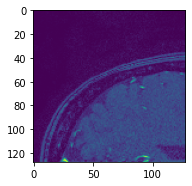

In [ ]:
display_img_mask(55,60)

In [ ]:
train_images = []
train_masks = []

for batch_num in range(7):
  for images, masks in train_ds.take(batch_num):  
        numpy_images = images.numpy()
        numpy_masks = masks.numpy()

        train_images.append(numpy_images)
        train_masks.append(numpy_masks)

numpy_images = np.concatenate(train_images)
numpy_masks = np.concatenate(train_masks)

In [ ]:
len(numpy_images)

1344

## Model Architecture

In [ ]:
#Define a Callback function to store metrics (statistics such as accuracy, loss, F1 score...)

import keras

from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

class MetricsHistory(keras.callbacks.Callback):
  
  def on_train_begin(self, logs={}):
    self.losses = []
    self.binary_accuracies = []
    self.val_losses = []
    self.val_binary_accuracies = []

  def on_epoch_end(self, batch, logs={}):
    self.losses.append(logs.get('loss'))
    self.binary_accuracies.append(logs.get('binary_accuracy'))
    self.val_losses.append(logs.get('val_loss'))
    self.val_binary_accuracies.append(logs.get('val_binary_accuracy'))
  
metrics_history = MetricsHistory()

In [ ]:
from keras.regularizers import l2
# instantiate regularizer
reg = l2(0.001)

### Simple CNN 1

In [ ]:
with tpu_strategy.scope():

  # Create a Keras model.
  model = keras.Sequential()

  #Add layers to the model
  # First layer of the CNN: Convolutional layer
  model.add(keras.layers.Conv2D(
      input_shape=(128,128, 1), # (height,width,channels) with channels = 1 indicating greyscale
      filters=64,
      kernel_size=(3, 3), # determine the width and height of the filter matrix / 2D convolution window
      activation='relu',
      activity_regularizer=reg))

  #Pooling layer performs downsampling, reducing dimensions of image to save computing power
  model.add(keras.layers.MaxPooling2D(
      pool_size=(2, 2),
      strides=(2, 2),
      activity_regularizer=reg))

  model.add(keras.layers.Dropout(0.2))


  # Second layer of the CNN
  # Convolutional layer
  model.add(keras.layers.Conv2D(
      filters=128,
      kernel_size=(3, 3),
      activation='relu',
      activity_regularizer=reg))

  #Another pooling layer
  model.add(keras.layers.MaxPooling2D( # Numbers 2, 2 denote the pool size, which halves the input in both spatial dimension.
      pool_size=(2, 2),
      strides=(2, 2),
      activity_regularizer=reg))

  model.add(keras.layers.Dropout(0.2))


  # Dense layers of the CNN.
  #'Flatten' layer converts 2D arrays produced by previous layers into a column vector
  model.add(keras.layers.Flatten()) # 'flatten' performs the input role
  model.add(
    keras.layers.Dense(
      units=64,
      activation='relu'))

  # model.add(
  #   keras.layers.Dense(
  #     units=32,
  #     activation='relu'))

  # Output layer of the CNN.
  model.add(
    keras.layers.Dense(
      units=1,
      activation='sigmoid'))


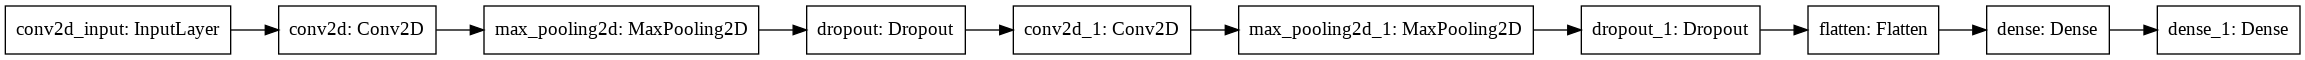

In [ ]:
tf.keras.utils.plot_model(model, rankdir='LR')

In [ ]:
model.summary()

### Simple CNN 2

Same number of layers but fewer filters compared to Simple CNN 1

In [ ]:
with tpu_strategy.scope():

  # Create a Keras model.
  model = keras.Sequential()

  #Add layers to the model
  # First layer of the CNN: Convolutional layer
  model.add(keras.layers.Conv2D(
      input_shape=(128,128, 1), # (height,width,channels) with channels = 1 indicating greyscale
      filters=32,
      kernel_size=(3, 3), # determine the width and height of the filter matrix / 2D convolution window
      activation='relu',
      activity_regularizer=reg))
  
  #Pooling layer performs downsampling, reducing dimensions of image to save computing power
  model.add(keras.layers.MaxPooling2D(
      pool_size=(2, 2),
      strides=(2, 2),
      activity_regularizer=reg))
  
  model.add(keras.layers.Dropout(0.2))


  # Second layer of the CNN
  # Convolutional layer
  model.add(keras.layers.Conv2D(
      filters=64,
      kernel_size=(3, 3),
      activation='relu',
      activity_regularizer=reg))

  #Another pooling layer
  model.add(keras.layers.MaxPooling2D( # Numbers 2, 2 denote the pool size, which halves the input in both spatial dimension.
      pool_size=(2, 2),
      strides=(2, 2),
      activity_regularizer=reg))
  
  model.add(keras.layers.Dropout(0.2))

  # Dense layers of the CNN.
  #'Flatten' layer converts 2D arrays produced by previous layers into a column vector
  model.add(keras.layers.Flatten()) # 'flatten' performs the input role

  model.add(
    keras.layers.Dense(
      units=32,
      activation='relu'))

  # Output layer of the CNN.
  model.add(
    keras.layers.Dense(
      units=1,
      activation='sigmoid'))

### Simple CNN3 

CNN2 without Max Pooling

In [ ]:
with tpu_strategy.scope():

  # Create a Keras model.
  model = keras.Sequential()

  #Add layers to the model
  # First layer of the CNN: Convolutional layer
  model.add(keras.layers.Conv2D(
      input_shape=(128,128, 1), # (height,width,channels) with channels = 1 indicating greyscale
      filters=32,
      kernel_size=(3, 3), # determine the width and height of the filter matrix / 2D convolution window
      activation='relu',
      activity_regularizer=reg))
  
  model.add(keras.layers.Dropout(0.2))

  # Second layer of the CNN
  # Convolutional layer
  model.add(keras.layers.Conv2D(
      filters=64,
      kernel_size=(3, 3),
      activation='relu',
      activity_regularizer=reg))
  
  model.add(keras.layers.Dropout(0.2))

  # Dense layers of the CNN.
  #'Flatten' layer converts 2D arrays produced by previous layers into a column vector
  model.add(keras.layers.Flatten()) # 'flatten' performs the input role

  model.add(
    keras.layers.Dense(
      units=32,
      activation='relu'))

  # Output layer of the CNN.
  model.add(
    keras.layers.Dense(
      units=1,
      activation='sigmoid'))

## Training the Model

### Learning rate scheduler & Early Stopping

In [ ]:
def build_learning_rate_cycler(
    lr_start=1e-5,
    lr_max=5e-5,
    lr_min=1e-6,
    lr_rampup_epochs=10,
    lr_sustain_epochs=2,
    lr_exp_decay=0.9,
):
    lr_max = lr_max

    def lrfn(epoch):
        if epoch < lr_rampup_epochs:
            lr = (lr_max - lr_start) / lr_rampup_epochs * epoch + lr_start
        elif epoch < lr_rampup_epochs + lr_sustain_epochs:
            lr = lr_max
        else:
            lr = (lr_max - lr_min) * lr_exp_decay ** (
                epoch - lr_rampup_epochs - lr_sustain_epochs
            ) + lr_min
        return lr

    return lrfn

lr_cycler = build_learning_rate_cycler(
          lr_start=1e-4,
          lr_max=1e-3,
          lr_min=1e-4,
          lr_rampup_epochs=20,
          lr_sustain_epochs=0,
          lr_exp_decay=0.9,
      )   


In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
                    monitor='val_loss',
                    patience=25,
                    restore_best_weights=True,
                    mode='auto')

### Training Simple CNNs

In [ ]:
with tpu_strategy.scope():

  # train AND save weights 

  print('Creating and compiling model...')

  lr = 1e-4
  loss = tf.keras.losses.binary_crossentropy
  metrics = ['binary_accuracy']

  model.compile(optimizer=Adam(learning_rate=lr), loss=loss, metrics=metrics)

  print('Fitting model...')
  history=model.fit(
      train_ds,
      epochs=100, 
      steps_per_epoch=5, 
      validation_data=val_ds, 
      validation_steps=10, 
      callbacks=[metrics_history, early_stopping]) 

  # save_model_path = "/content/drive/My Drive/Masters Project/Vascular Segmentation/Model Weights/128 x 128 Binary Classification"
  # model.save(os.path.join(save_model_path, 'lr=1e-3_CNN3.h5'))

Creating and compiling model...
Fitting model...
Epoch 1/100
5/5 [==============================] - 14s 2s/step - loss: 2.6917 - binary_accuracy: 0.4969 - val_loss: 3.8566 - val_binary_accuracy: 0.5422
Epoch 2/100
5/5 [==============================] - 3s 668ms/step - loss: 2.6746 - binary_accuracy: 0.4813 - val_loss: 3.4736 - val_binary_accuracy: 0.5031
Epoch 3/100
5/5 [==============================] - 3s 716ms/step - loss: 2.4919 - binary_accuracy: 0.4906 - val_loss: 3.5710 - val_binary_accuracy: 0.4469
Epoch 4/100
5/5 [==============================] - 3s 619ms/step - loss: 2.4440 - binary_accuracy: 0.5437 - val_loss: 3.3916 - val_binary_accuracy: 0.5266
Epoch 5/100
5/5 [==============================] - 2s 620ms/step - loss: 2.1795 - binary_accuracy: 0.5031 - val_loss: 3.2309 - val_binary_accuracy: 0.4688
Epoch 6/100
5/5 [==============================] - 3s 733ms/step - loss: 2.2386 - binary_accuracy: 0.5437 - val_loss: 3.1014 - val_binary_accuracy: 0.5125
Epoch 7/100
5/5 [======

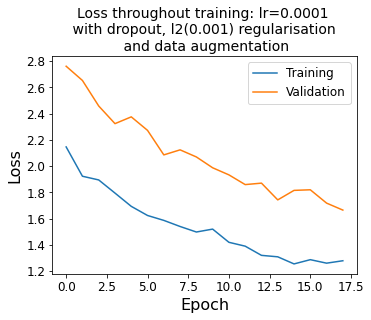

In [ ]:
# plot training & validation loss

plt.figure(figsize=(12, 4)) 

plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.xlabel('Epoch', size=16)
plt.ylabel('Loss', size=16)
plt.xticks(size=12)
plt.yticks(size=12)
plt.title('Loss throughout training: lr={} \n with dropout, l2(0.001) regularisation \n and data augmentation'.format(lr), size=14)
plt.legend(prop={'size': 12})

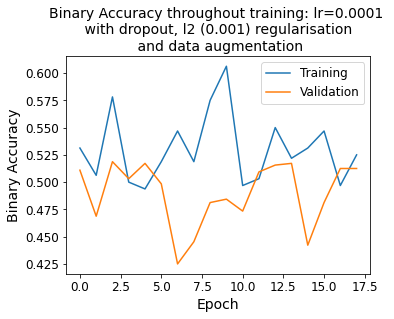

In [ ]:
# plot training & validation accuracy

plt.figure(figsize=(12, 4)) 

plt.subplot(1,2,2)
plt.plot(history.history['binary_accuracy'], label='Training')
plt.plot(history.history['val_binary_accuracy'], label='Validation')
plt.xlabel('Epoch', size=14)
plt.ylabel('Binary Accuracy', size=14)
plt.xticks(size=12)
plt.yticks(size=12)
plt.title('Binary Accuracy throughout training: lr={} \n with dropout, l2 (0.001) regularisation \n and data augmentation'.format(lr), size=14)
plt.legend(prop={'size': 12})

## Find optimal Learning Rate

In [ ]:
model.compile(optimizer=Adam(learning_rate=lr), loss=loss, metrics=metrics)

initial_weights = model.get_weights()
len(initial_weights)

8

In [ ]:
def find_learning_rate(num_rates=50):
    rates = np.logspace(-5, -1, num=num_rates)
    img, label = list(train_ds.take(1))[0]
    losses = []
    for rate in tqdm(rates):

          model.compile(optimizer=Adam(learning_rate=rate), loss=loss, metrics=metrics)
          model.set_weights(initial_weights)
          model.fit(img, label, epochs=10, verbose=0)
          losses.append(model.history.history['loss'][0])
    return losses, rates

losses, rates = find_learning_rate(50)

100%|██████████| 50/50 [23:23<00:00, 28.07s/it]


(array([0., 1., 2., 3., 4., 5., 6., 7., 8.]),
 <a list of 9 Text major ticklabel objects>)

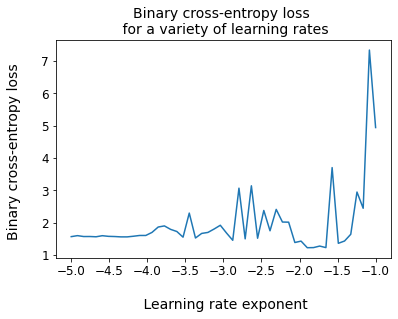

In [ ]:
plt.plot(np.log10(rates), losses)
plt.title('Binary cross-entropy loss \n for a variety of learning rates', size=14)
plt.xlabel('\n Learning rate exponent', size=14)
plt.ylabel('Binary cross-entropy loss \n', size=14)
plt.xticks(size=12)
plt.yticks(size=12)

### Pre-trained Model

In [ ]:
# 1. Start a new run
wandb.init(project='vascular_segmentation')

# 2. Save model inputs and hyperparameters
config = wandb.config
# config.learning_rate = 0.01

with tpu_strategy.scope():

  model = unet_model(OUTPUT_CHANNELS)

  model.compile(optimizer=AdamW(weight_decay=1e-6),
                loss=loss,
                metrics=metrics)

  EPOCHS = 50

  history = model.fit(train_ds, epochs=EPOCHS, steps_per_epoch=5,
                            validation_data=val_ds, validation_steps=10, callbacks = [tf.keras.callbacks.LearningRateScheduler(lr_cycler, verbose=1), WandbCallback(), early_stopping])

ValueError: ignored

# Testing

### Load test data in TFRecords format

In [ ]:
print('Loading and preprocessing test data (empty masks)...')

test_empty_gcs_pattern = "gs://tfrecords_patches_binary/test_empty*"
test_empty_filenames = tf.io.gfile.glob(test_empty_gcs_pattern)
test_empty_ds = tf.data.TFRecordDataset(test_empty_filenames)

test_empty_ds = test_empty_ds.map(_parse_image_function)
test_empty_ds = test_empty_ds.map(_unpack_proto)

Loading and preprocessing test data (empty masks)...


In [ ]:
print('Loading and preprocessing test data (non-empty masks)...')

test_non_empty_gcs_pattern = "gs://tfrecords_patches_binary/test_non_empty*"
test_non_empty_filenames = tf.io.gfile.glob(test_non_empty_gcs_pattern)
test_non_empty_ds = tf.data.TFRecordDataset(test_non_empty_filenames)

test_non_empty_ds = test_non_empty_ds.map(_parse_image_function)
test_non_empty_ds = test_non_empty_ds.map(_unpack_proto)


Loading and preprocessing test data (non-empty masks)...


In [ ]:
test_datasets = [test_non_empty_ds.repeat(), test_empty_ds.repeat()]
test_ds = tf.data.experimental.sample_from_datasets(test_datasets, [0.5,0.5])

test_ds = prepare_data(test_ds)
test_ds

<PrefetchDataset shapes: ((None, 128, 128, 1), (None, 1)), types: (tf.float32, tf.int64)>

In [ ]:
test_pairs = list(test_ds.take(1))
test_images = [pair[0] for pair in test_pairs]
test_images_to_display = np.concatenate(test_images)

test_masks = [pair[1] for pair in test_pairs]
test_masks = np.concatenate(test_masks)

In [ ]:
len(test_images_to_display)

64

### Display test images with true and predicted masks

In [ ]:
print('Predicting masks on test data...')

test_preds = [model.predict(img) for img in test_images]
test_preds = np.concatenate(test_preds)

Predicting masks on test data...


Text(0.5, 1.0, 'Distribution of true labels')

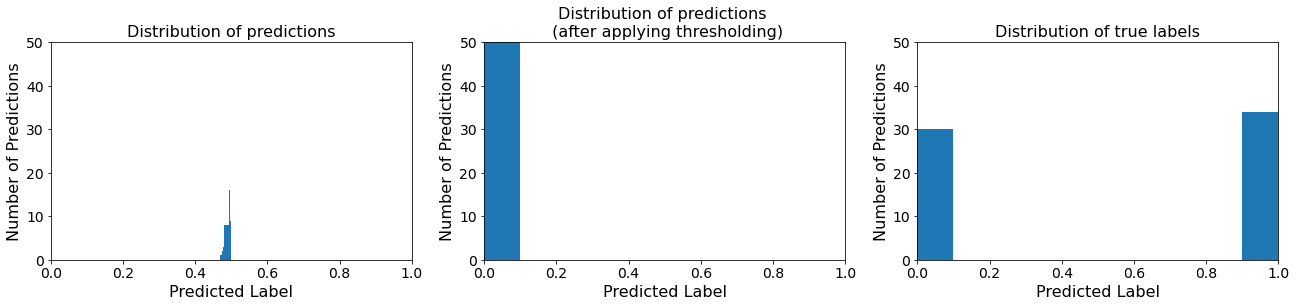

In [ ]:
plt.figure(figsize=(22, 4)) 

plt.subplot(1,3,1)
plt.hist(test_preds)
plt.xlim([0,1])
plt.ylim([0,50])
plt.xlabel('Predicted Label', size=16)
plt.ylabel('Number of Predictions', size=16)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title('Distribution of predictions', size=16)

plt.subplot(1,3,2)
test_preds_binary = np.where(test_preds < 0.5,0, 1)
plt.hist(test_preds_binary)
plt.xlim([0,1])
plt.ylim([0,50])
plt.xlabel('Predicted Label', size=16)
plt.ylabel('Number of Predictions', size=16)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title('Distribution of predictions \n (after applying thresholding)', size=16)

plt.subplot(1,3,3)
plt.hist(test_masks)
plt.xlim([0,1])
plt.ylim([0,50])
plt.xlabel('Predicted Label', size=16)
plt.ylabel('Number of Predictions', size=16)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title('Distribution of true labels', size=16)

In [ ]:
def compare_img_mask(images, masks, preds, img_num):

  """
  Display original image with mask, true mask and predicted mask for a specified image number
  
  Args:
  train_, test_ or valid_ + images/masks/preds
  """
  
  plt.imshow(images[img_num].reshape((128,128)))

  print('True label: {}'.format(test_masks[img_num]))
  print('Predicted label: {}'.format(test_preds[img_num]))

True label: [1]
Predicted label: [0.00146729]


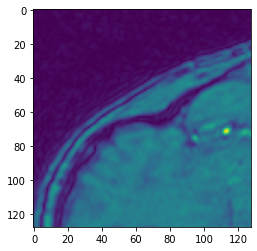

In [ ]:
compare_img_mask(test_images_to_display, test_masks, test_preds, 30)

True label: [1]
Predicted label: [0.02509215]


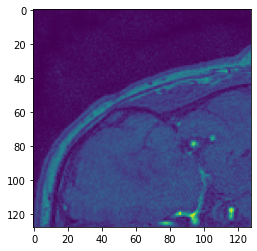

In [ ]:
compare_img_mask(test_images_to_display, test_masks, test_preds, 40)

### Define Confusion Matrix

In [ ]:
target_names = ['No aneurysm', 'Aneurysm']

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='TRUE LABEL \n',
           xlabel='\n PREDICTED LABEL')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), ha="center",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

np.set_printoptions(precision=2)

### Plot Confusion Matrix

Confusion matrix, without normalization
[[11 19]
 [11 23]]


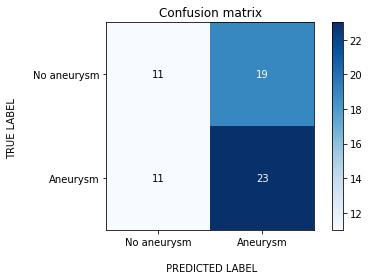

In [ ]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(test_masks, test_preds_binary, classes=target_names,
                      title='Confusion matrix')

plt.show()

In [ ]:
from sklearn.metrics import f1_score

f1_score(test_masks, test_preds_binary)

0.605263157894737